In [33]:
import sys
import os
from tqdm import tqdm, trange
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import json
from Models.AutoEncoder import *
from utils.utils import *
from sklearn.metrics import f1_score
import numpy as np
from dotenv import load_dotenv
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
from time import time


In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
# 데이터 준비
cat_features = [
    'Gender',
    'Zipcode',
    'Day',
    'Card Brand',
    'Card Type',
    'Has Chip',
    'Whether Security Chip is Used',
    'Error Message',
    'WeekDay',
    'Credit Signal',
    'PIN Change',
    'Security Level'
]
num_features = [
    'Current Age',
    'Retirement Age',
    'Per Capita Income - Zipcode',
    'Yearly Income',
    'Total Debt',
    'Credit Score',
    'Valid Month',
    'Credit Limit',
    'Since Open Month',
    'Year PIN last Changed',
    'Amount',
    'Credit Util',
    'Years Changed PIN',
    'Security Score'
]
discarded = [
    'User',
    'Birth Year',
    'Birth Month',
    'Year',
    'Month',
    'Merchandise Code',
    'Card',
    'Card Number',
    'Expires',
    'Acct Open Date',
]

In [25]:
(train_cat_X, train_num_X, train_y), (valid_cat_X, valid_num_X, valid_y), _ , _ = dt_process_data(
        '../Data/[24-2 DS_Project2] Data.csv', 
        cat_features, 
        num_features,
        discarded
    )

TRANSITION
IQR
SPLIT
DISCARD
SCALE
ENCODE
TARGET
TRAIN CAT/NUM
VALID CAT/NUM
RETURN


In [26]:
train_dataset = AE_Dataset(train_cat_X, train_num_X, train_y, device)
valid_dataset = AE_Dataset(valid_cat_X, valid_num_X, valid_y, device)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [27]:
model = AutoEncoder(encoding_dim=26, cat_features=cat_features, num_features=num_features).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [28]:
# 4. 학습 및 평가
best_loss = 0
l1_lambda = config["l1_lambda"]
model_filename = f"AE_dim{config['encoding_dim']}_batch{config['batch_size']}_lr{config['lr']:.6f}_l1{l1_lambda:.6f}.pth"


In [29]:
# tqdm으로 에포크 진행률 표시
for epoch in trange(3, desc="Training"):
    # 학습 단계
    model.train()
    train_loss = 0
    # tqdm으로 배치 진행률 표시
    for cat_features, num_features, _ in tqdm(train_loader, desc=f"Epoch {epoch}", leave=False):
        optimizer.zero_grad()
        y_hat, y = model(cat_features, num_features)

        # MSE 손실 계산
        mse_loss = criterion(y_hat, y)

        # L1 정규화 계산
        l1_reg = torch.tensor(0., requires_grad=True).to(device)
        for param in model.parameters():
            l1_reg = l1_reg + torch.norm(param, 1)

        # 총 손실 = MSE 손실 + L1 정규화
        loss = mse_loss + l1_lambda * l1_reg

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # 평균 train_loss 계산
    train_loss /= len(train_loader)

    # 검증 단계 (10 에포크마다)
    if epoch % 10 == 0:
        #run["metrics/train_loss"].log(train_loss)
        model.eval()
        valid_loss = 0
        reconstruction_errors = []
        all_labels = []

        with torch.no_grad():
            for cat_features, num_features, _ in valid_loader:
                y_hat, y = model(cat_features, num_features)
                batch_loss = criterion(y_hat, y)
                valid_loss += batch_loss.item()

                sample_errors = torch.mean((y_hat - y) ** 2, dim=1)
                reconstruction_errors.extend(sample_errors.cpu().numpy())
                #all_labels.extend(labels.cpu().numpy())

            # 성능 평가


            # 결과 로깅
            #run["metrics/valid_loss"].log(valid_loss)

            print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Valid Loss = {valid_loss:.4f}")

            # 최고 성능 모델 저장 및 혼동 행렬 생성
            if loss < best_loss:
                best_loss = loss
                #model_path = os.path.join(save_dir, model_filename)
                #torch.save(model.state_dict(), model_path)
                #run["artifacts/best_model"].upload(model_path)

Epoch 0: 100%|█████████▉| 5728/5738 [00:42<00:00, 125.47it/s]
                                                             

Epoch 0: Train Loss = 3.7253, Valid Loss = 385.6920


Training: 100%|██████████| 3/3 [02:14<00:00, 44.88s/it]      


In [30]:
latent_variables = model.get_embedding(
    torch.tensor(train_cat_X.values, dtype=torch.long).to(device),
    torch.tensor(train_num_X.values, dtype=torch.float).to(device),
)

In [32]:
latent_variables.shape

torch.Size([734352, 26])

In [42]:
def visualize_latent_space(latent_vectors, perplexity=30, n_iter=250):
    # t-SNE 모델 초기화 및 학습
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
    latent_tsne = tsne.fit_transform(latent_vectors.cpu().detach().numpy())

    # 시각화
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], cmap='tab10', alpha=0.6)
    plt.colorbar(scatter)

    plt.title('t-SNE Visualization of Latent Space')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')

    # 클래스별 중심점 계산 및 표시
    # for label in np.unique(labels):
    #    mask = labels == label
    #    centroid = np.mean(latent_tsne[mask], axis=0)
    #    plt.annotate(f'Class {label}',
    #                 centroid,
    #                 xytext=(10, 10),
    #                 textcoords='offset points',
    #                 bbox=dict(alpha=0.5, fc='white'))

    plt.tight_layout()
    plt.show()

C:\Users\kim00\AppData\Local\Temp\ipykernel_9008\1002076768.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], cmap='tab10', alpha=0.6)


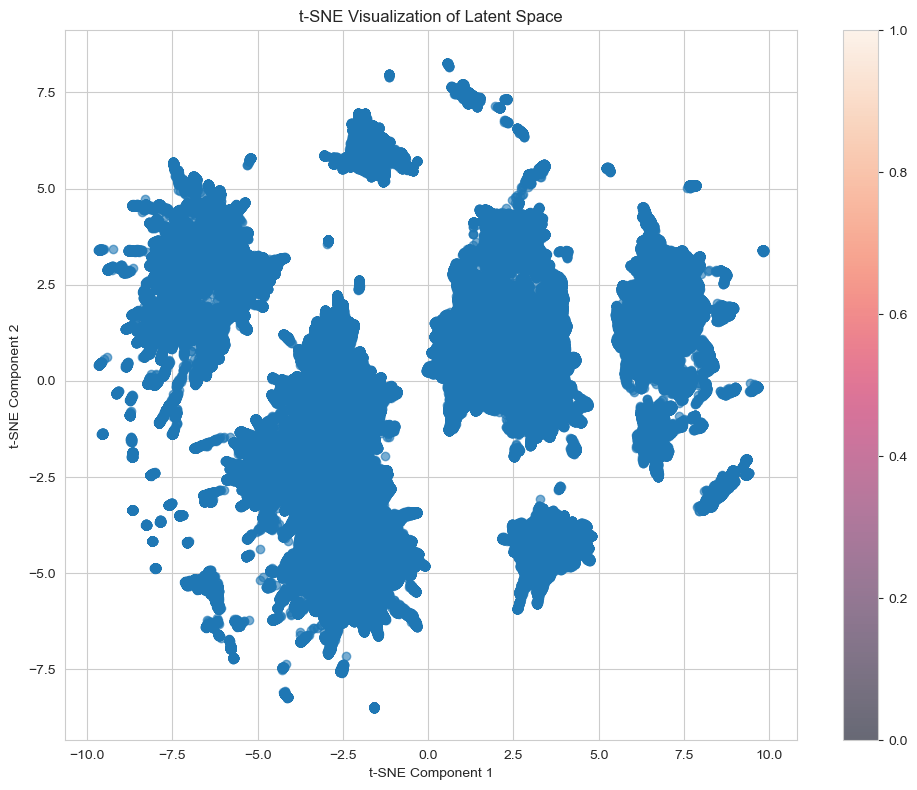

In [43]:
visualize_latent_space(latent_variables)